# Covid 19 - Visualização Brasil
Dados oriundos de https://brasil.io/dataset/covid19/caso 
*Cleuton Sampaio*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('./covid19-86691a57080d4801a240e49035b292fc.csv') 
df.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-04-15,AC,Acrelândia,city,11,0,True,15256.0,1200013.0,72.10278,NaN
1,2020-04-15,AC,Bujari,city,1,0,True,10266.0,1200138.0,9.74089,NaN
2,2020-04-15,AC,Cruzeiro do Sul,city,2,0,True,88376.0,1200203.0,2.26306,NaN
3,2020-04-15,AC,Plácido de Castro,city,10,1,True,19761.0,1200385.0,50.60473,0.1
4,2020-04-15,AC,Porto Acre,city,1,0,True,18504.0,1200807.0,5.40424,NaN


In [29]:
list_cidades = df.groupby("city").count().index.tolist()


In [30]:
list_cidades

['Abaetetuba',
 'Abaeté',
 'Abaíra',
 'Abreu e Lima',
 'Acari',
 'Acará',
 'Acopiara',
 'Acrelândia',
 'Adamantina',
 'Adustina',
 'Afonso Cláudio',
 'Agudos',
 'Ajuricaba',
 'Alagoinhas',
 'Alcinópolis',
 'Alegrete',
 'Alfenas',
 'Alfredo Chaves',
 'Aliança',
 'Almenara',
 'Almirante Tamandaré',
 'Aloândia',
 'Alpercata',
 'Alta Floresta',
 'Altamira',
 'Altamira do Maranhão',
 'Alto Alegre',
 'Alto Rio Novo',
 'Altos',
 'Alvorada',
 'Americana',
 'Amontada',
 'Amparo',
 'Américo Brasiliense',
 'Anamã',
 'Ananindeua',
 'Andradina',
 'Angra dos Reis',
 'Anhanguera',
 'Anita Garibaldi',
 'Anori',
 'Anta Gorda',
 'Antônio Carlos',
 'Anápolis',
 'Aparecida de Goiânia',
 'Apiaí',
 'Apodi',
 'Apucarana',
 'Aquiraz',
 'Aracaju',
 'Aracati',
 'Araci',
 'Aracoiaba',
 'Aracruz',
 'Aragoiânia',
 'Araguari',
 'Araguaína',
 'Arapongas',
 'Araranguá',
 'Araraquara',
 'Araras',
 'Araruama',
 'Araruna',
 'Araucária',
 'Araxá',
 'Araçariguama',
 'Araçatuba',
 'Araçoiaba',
 'Araçoiaba da Serra',
 'Arco

Vamos geocodificar as cidades buscando-as pela Geocode API da Google. Você precisa obter uma API Key: https://console.cloud.google.com/apis/ Se quiser, pode usar o arquivo geocodificado que eu salvei. 

In [ ]:
import requests
import json
cidades = {}
cidades_nao_encontradas = []
url = 'https://maps.googleapis.com/maps/api/geocode/json'

params = dict(
    key='** USE SUA API KEY**'
)
inx = 0
start=None # Inform None to process all cities. Inform  a city to begin processing after it
start_saving=False
for city in list_cidades:
    if start != None:
        if city == start:
            start_saving = True
    else:
        start_saving = True
    if start_saving:
        params['address'] = city + ',brasil'
        resp = requests.get(url=url, params=params)
        data = resp.json()
        try: 
            latitude  = data['results'][0]['geometry']['location']['lat']
            longitude = data['results'][0]['geometry']['location']['lng']
            print(city,latitude,longitude)
            cidades[city]={'latitude': latitude, 'longitude': longitude}
            inx = inx + 1
        except: 
            print("Erro na cidade: ",city)
            cidades_nao_encontradas.append(city)
    else:
        print('Pulando a cidade já processada:',city)
print('Cidades salvas no arquivo:',inx)
print('Cidades não encontradas',cidades_nao_encontradas)
with open('cidades.json', 'w') as fp:
    json.dump(cidades, fp)    

In [ ]:
print(json.dumps(cidades))


Eu salvei um arquivo chamado "cidades.json" com a geocodificação, de modo a evitar acessar a API novamenete. 
Agora, preciso baixar um mapa contendo o Brasil. Escolhi o centro usando o Google Maps e ajustei o zoom, o tamanho e a escala. Note que você vai precisar de uma chave de API.

In [313]:
#-13.6593766,-58.6914406
latitude  = -13.6593766
longitude = -50.6914406
zoom = 4
size = 530
scale = 2
apikey = "** SUA API KEY**"
gmapas = "https://maps.googleapis.com/maps/api/staticmap?center=" + str(latitude) + "," + str(longitude) + \
    "&zoom=" + str(zoom) + \
    "&scale=" + str(scale) + \
    "&size=" + str(size) + "x" + str(size) + "&key=" + apikey

with open('mapa.png', 'wb') as handle:
        response = requests.get(gmapas, stream=True)

        if not response.ok:
            print(response)

        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)

![](./mapa.png)

Agora, preciso de uma função para usar a projeção de Mercator e calcular as bordas do mapa que eu baixei. Eu baixei desta resposta do StackOverflow: https://stackoverflow.com/questions/12507274/how-to-get-bounds-of-a-google-static-map E funciona melhor do que a que estava utilizando.

In [314]:
import MercatorProjection
centerLat = latitude
centerLon = longitude
mapWidth = size
mapHeight = size
centerPoint = MercatorProjection.G_LatLng(centerLat, centerLon)
corners = MercatorProjection.getCorners(centerPoint, zoom, mapWidth, mapHeight)
print(corners)

{'N': 9.457144095158089, 'E': -27.400424974999996, 'S': -34.73487934918346, 'W': -73.98245622499999}


Gerei um novo Dataframe contendo as latitudes, longitudes e quantidade de casos: 

In [82]:
casos = df.groupby("city")['confirmed'].sum()
df2 = pd.DataFrame.from_dict(cidades,orient='index')
df2['casos'] = casos
print(df2.head())

               latitude  longitude  casos
Abaetetuba    -1.725310 -48.879800     28
Abaeté       -19.157380 -45.444997      4
Abaíra       -13.278206 -41.740739      2
Abreu e Lima  -7.920132 -34.908854     60
Acari         -6.435123 -36.640838      2


Agora, vou acrescentar um atributo com a cor do ponto, de acordo com uma heurística de quantidade de casos: Quanto mais, mais vermelho: 

In [ ]:
def calcular_cor(valor):
    cor = 'r'
    if valor <= 10: 
        cor = '#ffff00'
    elif valor <= 30:
        cor = '#ffbf00'
    elif valor <= 50:
        cor = '#ff8000'
    return cor
                
df2['cor'] = [calcular_cor(codigo) for codigo in df2['quantidade']]

In [84]:
df2.head()

,latitude,longitude,casos,cor
Abaetetuba,-1.725310,-48.879800,28,#ffbf00
Abaeté,-19.157380,-45.444997,4,#ffff00
Abaíra,-13.278206,-41.740739,2,#ffff00
Abreu e Lima,-7.920132,-34.908854,60,#ff8000
Acari,-6.435123,-36.640838,2,#ffff00


Vamos ordenar pela quantidade de casos: 

In [ ]:
df2 = df2.sort_values(['casos'])


Temos alguns "outliers", ou seja, coordenadas muito fora do país. Provavelmente, problemas de geocodificação. Vamos retirá-las: 

In [169]:
print(df2.loc[(df2['latitude'] > 20) | (df2['longitude']< -93)])
df3 = df2.drop(df2[(df2.latitude > 20) | (df2.longitude < -93)].index)

           latitude   longitude  casos      cor
Rincão    25.677552 -100.437115      2  #ffff00
Pontal    40.727549  -74.165620      6  #ffff00
Eldorado  41.292494  -72.788264      7  #ffff00
Estrela   28.025502  -82.572325     30  #ffbf00
Arcos     33.402952 -111.926630     32  #ffbf00


Agora dá para plotar um gráfico utilizando aquela imagem baixada. Eu tive que ajustar as coordenadas de acordo com os limites do retângulo, calculados pela projeção de Mercator: 

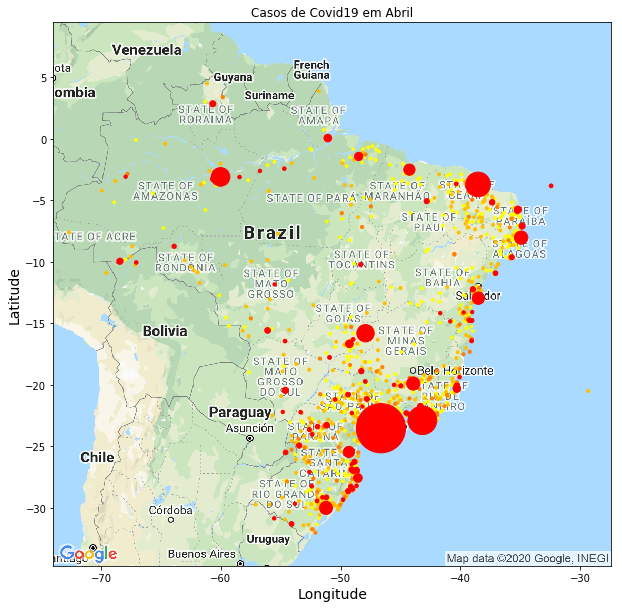

In [317]:
import matplotlib.image as mpimg
mapa=mpimg.imread('./mapa.png')
fig, ax = plt.subplots(figsize=(10, 10))
#{'N': 20.88699826581544, 'E': -15.535190599999996, 'S': -43.89198802990045, 'W': -85.84769059999999}
plt.imshow(mapa, extent=[corners['W'],corners['E'],corners['S'],corners['N']], alpha=1.0, aspect='auto')
ax.scatter(df3['longitude'],df3['latitude'], c=df3['cor'],s=8+df3['casos']*0.03)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
ax.set_title('Casos de Covid19 em Abril')
plt.show()